In [1]:
import pandas as pd

In [2]:
RESULTS_PATH = '../results/'

In [5]:
import os
import json
from plotnine import ggplot, aes, geom_line, labs, theme_bw, theme, element_text, facet_wrap, scale_y_log10

models = [d for d in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, d))]
variants = ['with_wind', 'without_wind']
metric_to_plot = ('MSE', 'RMSE', 'MAE', 'SMAPE', 'WMAPE', 'R2')
horizons = [1, 4, 8, 12, 16, 20, 24]

for metric in metric_to_plot:
    all_metrics_data = []
    for model in models:
        for variant in variants:
            filepath = f'{RESULTS_PATH}{model}/{variant}/all_metrics_horizon.json'
            if not os.path.exists(filepath):
                continue
            with open(filepath, 'r') as f:
                data_by_fold = json.load(f)
            for fold_idx, horizon_list in enumerate(data_by_fold):
                for horizon_idx, all_metrics in enumerate(horizon_list):
                    if horizon_idx >= len(horizons):
                        continue
                    horizon_value = horizons[horizon_idx]
                    if metric not in all_metrics:
                        continue
                    feature_metrics = all_metrics[metric]
                    for feature, value in feature_metrics.items():
                        all_metrics_data.append({
                            'model': model,
                            'variant': variant,
                            'horizon': horizon_value,
                            'feature': feature,
                            'metric_value': value
                        })
    if all_metrics_data:
        import pandas as pd
        horizon_df = pd.DataFrame(all_metrics_data)
        avg_horizon_df = horizon_df.groupby(['model', 'variant', 'horizon', 'feature']).agg(
            avg_metric=('metric_value', 'mean')
        ).reset_index()
        # Filtra grupos com pelo menos 2 pontos para evitar erro de plotagem
        grouping_cols = ['model', 'variant', 'feature']
        counts = avg_horizon_df.groupby(grouping_cols)['horizon'].transform('count')
        plottable_df = avg_horizon_df[counts > 1]
        if plottable_df.empty:
            print(f"Not enough data to plot for metric {metric}. Skipping.")
            continue
        plot = (
            ggplot(plottable_df, aes(x='horizon', y='avg_metric', color='model')) +
            geom_line() +
            facet_wrap('~ variant + feature', scales='free_y') +
            labs(
                title=f'Average {metric} by Prediction Horizon',
                x='Horizon',
                y=f'Average {metric}'
            ) +
            theme_bw() +
            theme(
                axis_text_x=element_text(angle=45, hjust=1),
                figure_size=(16, 10)
            )
        )
        if metric != 'R2' and metric != 'WMAPE' and not plottable_df['avg_metric'].le(0).any():
            plot += scale_y_log10()
            plot += labs(y=f'Average {metric} (log scale)')
        plot.save(f'../final_results_graphs/lines/line_{metric}.png', dpi=300, bbox_inches='tight')
    else:
        print(f"No horizon metrics files found for metric {metric} to generate plot.")


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 16 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/lines/line_MSE.png
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 16 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/lines/line_RMSE.png
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 16 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/lines/line_RMSE.png
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-pa

/tmp/ipykernel_2338/3657924271.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['value'].replace([np.inf, -np.inf], np.nan, inplace=True)


Features únicas: ['Temperature' 'Humidity' 'Wind_Speed_kmh' 'Soil_Moisture'
 'Soil_Temperature' 'Wind_Dir_Sin' 'Wind_Dir_Cos'
 'Precipitation_accumulated']
Modelos únicos: ['Transformer' 'XGB' 'TSMixer' 'TiDE' 'GRU' 'LSTM' 'NHiTS' 'TCN']
Variantes únicas: ['with_wind' 'without_wind']

Métrica: MSE | Variante: with_wind
model                                GRU           LSTM         NHiTS  \
feature                                                                 
Humidity                      586.324535     337.796914  3.013340e+02   
Precipitation_accumulated   12199.463504   12251.125510  1.493597e+04   
Soil_Moisture              530660.678902  463633.699792  1.285858e+06   
Soil_Temperature               33.507565      33.212620  4.139428e+01   
Temperature                    51.405268      21.159921  7.039788e+02   
Wind_Dir_Cos                    0.516213       0.333163  3.423383e-01   
Wind_Dir_Sin                    0.525692       0.320206  1.275844e+00   
Wind_Speed_kmh        

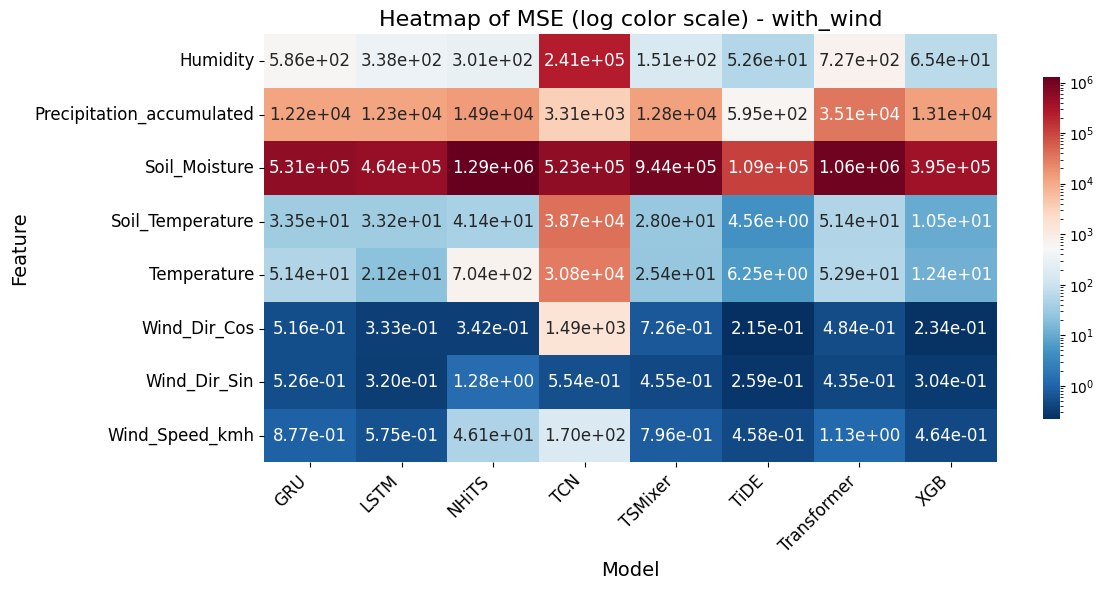

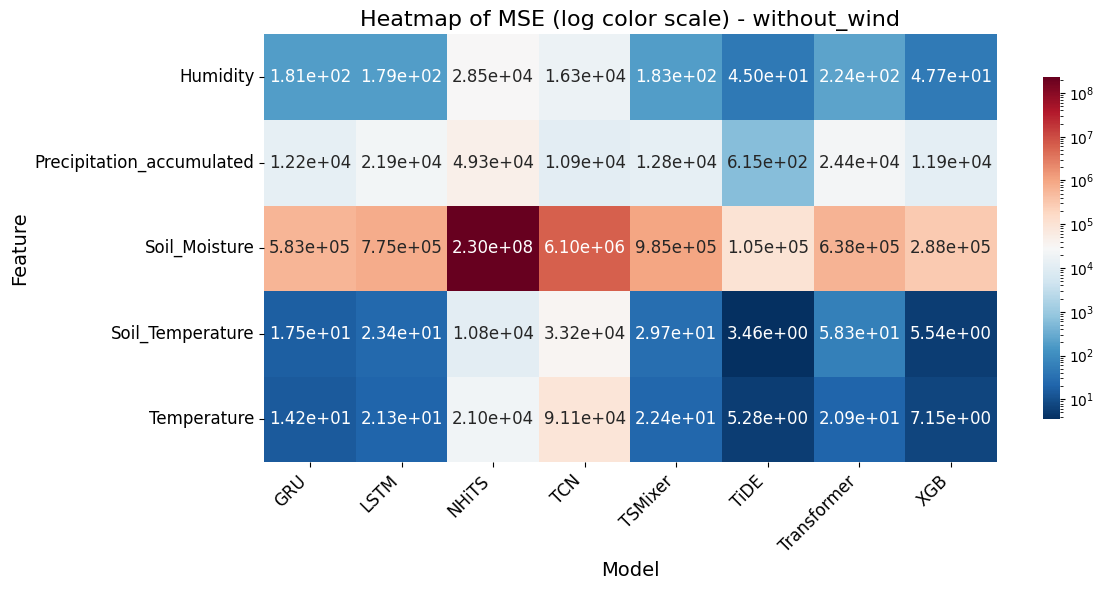

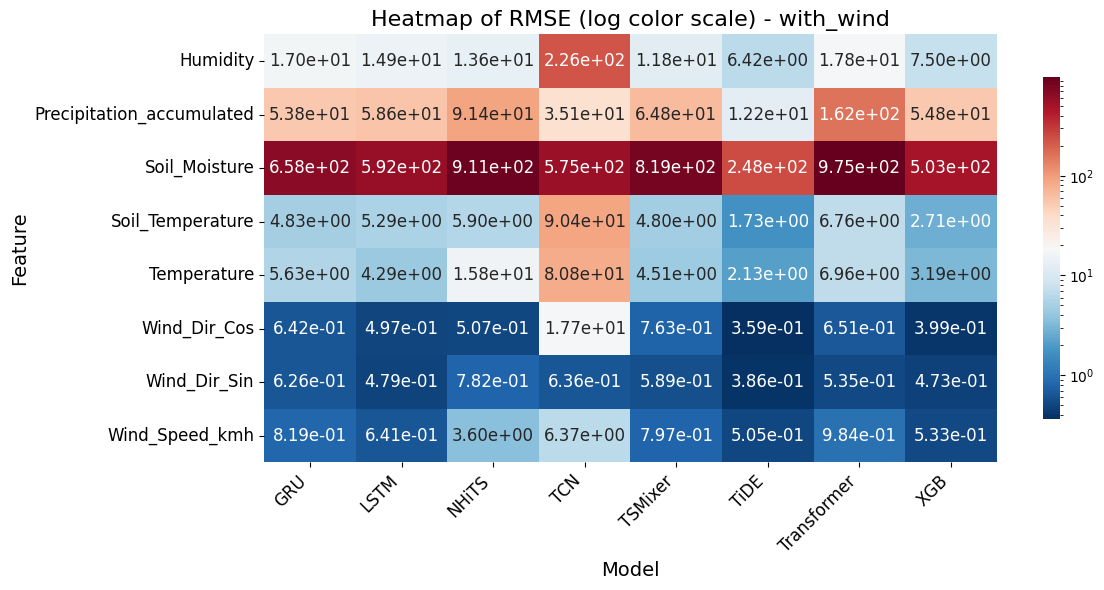

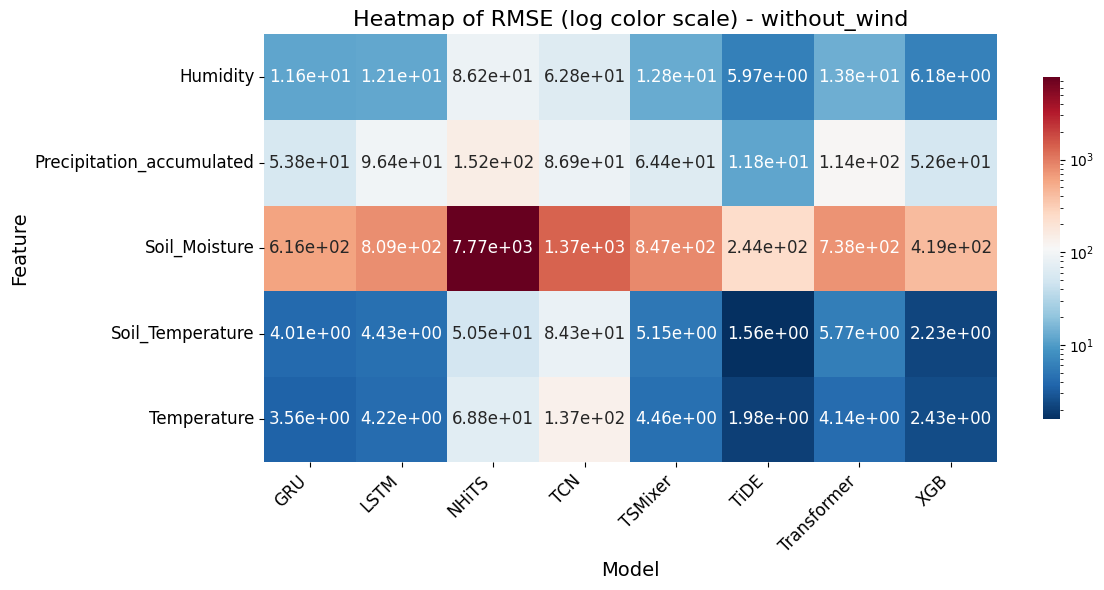

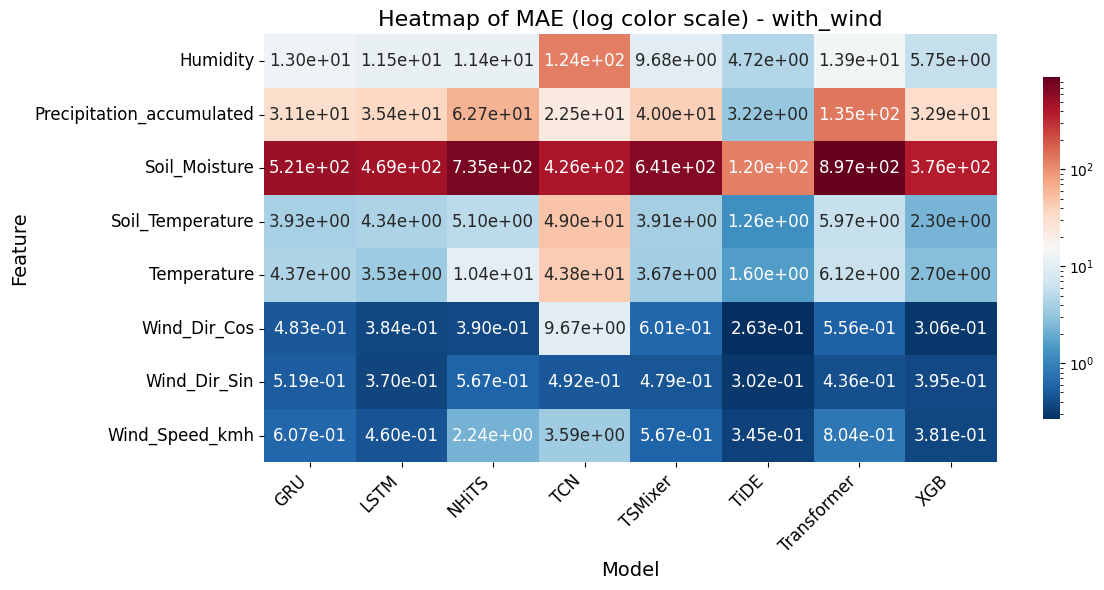

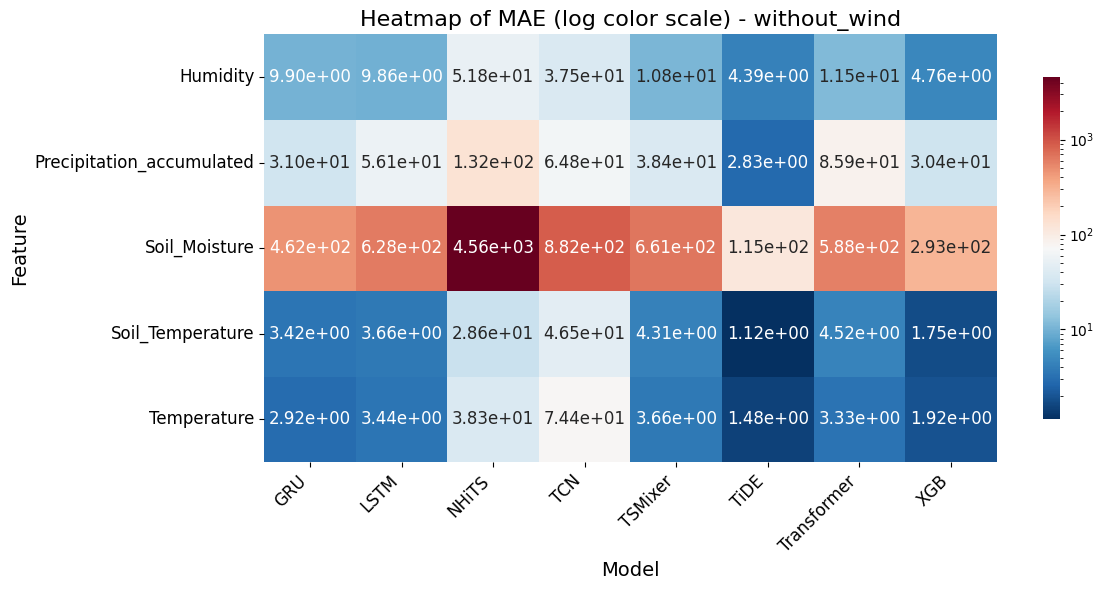

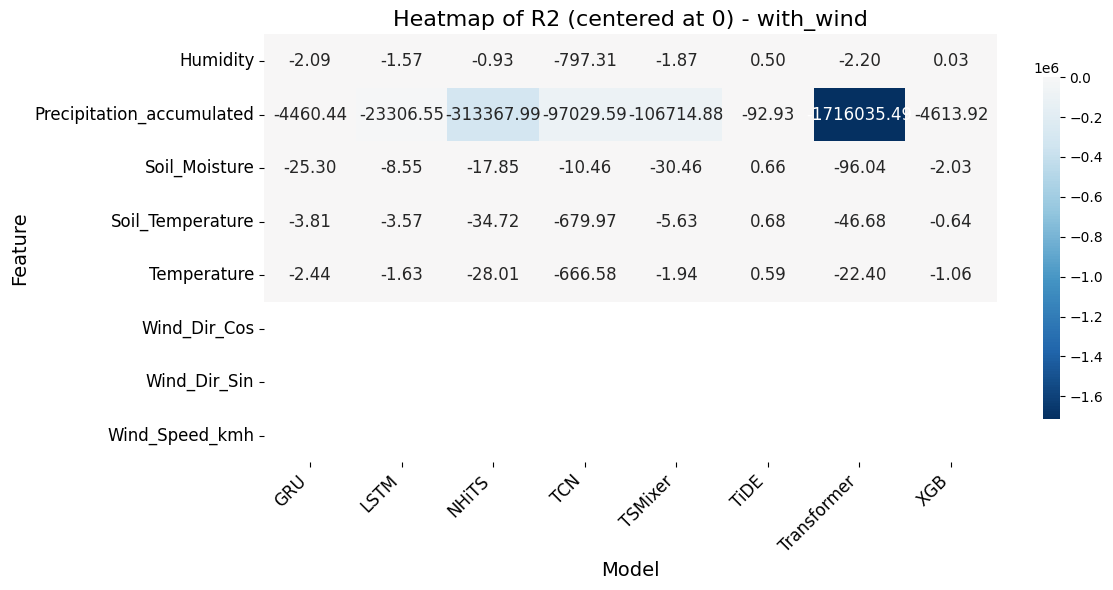

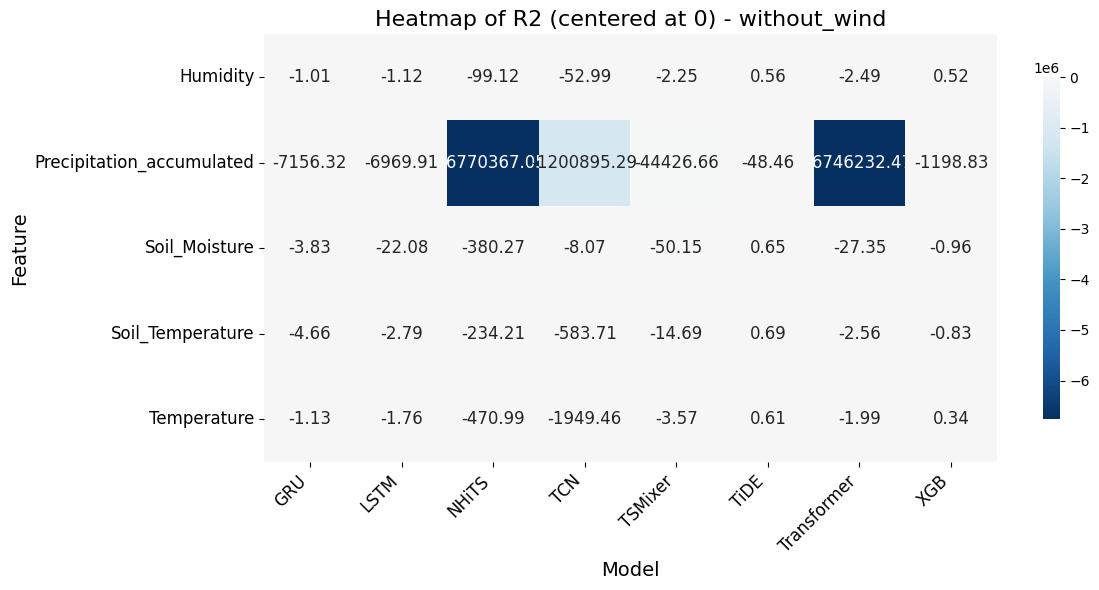

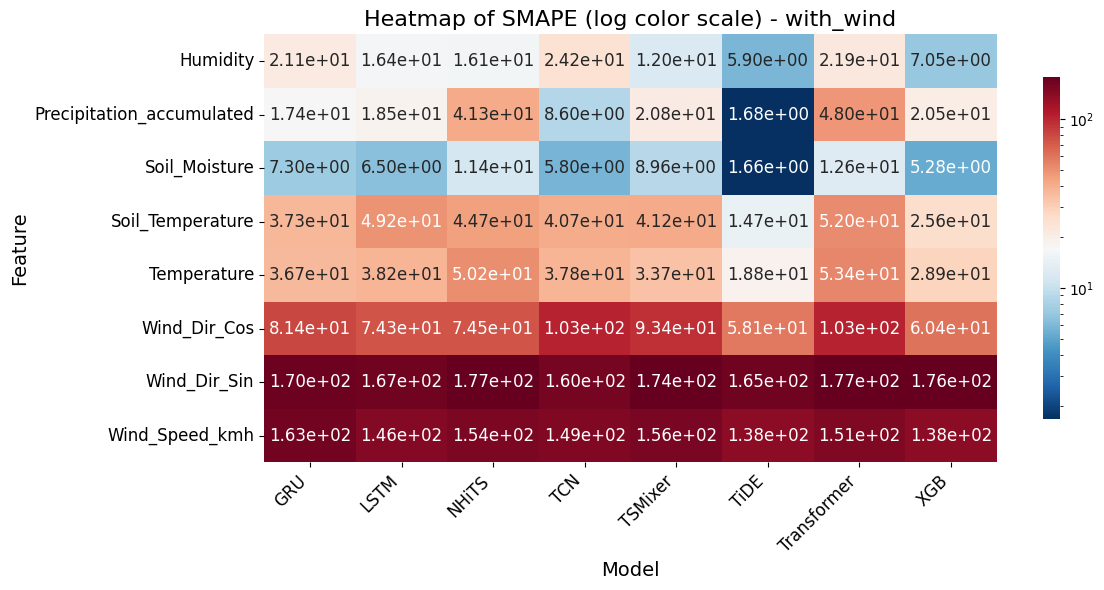

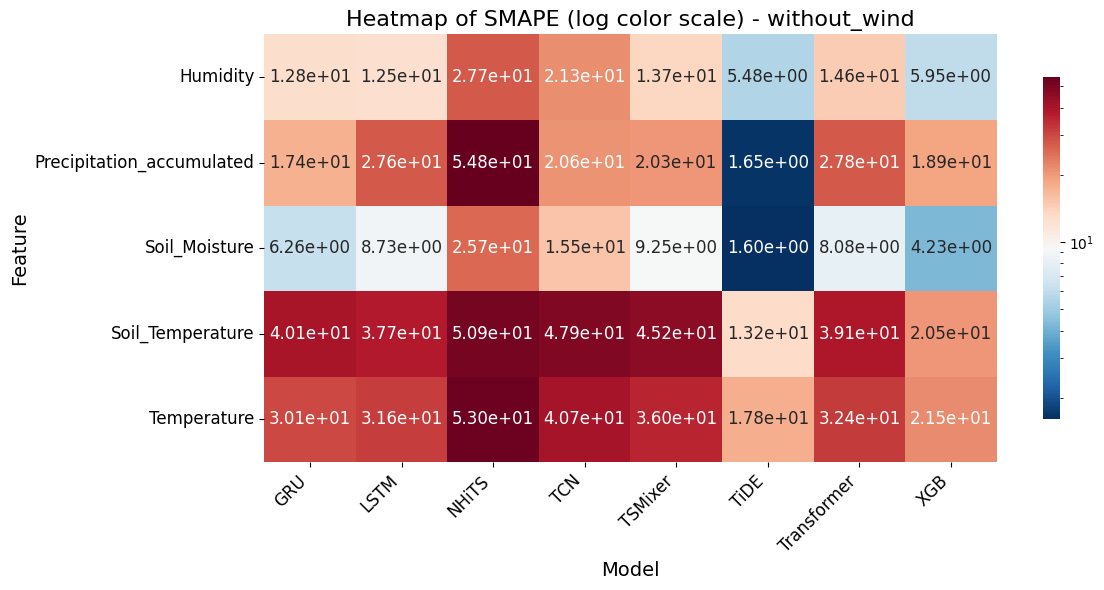

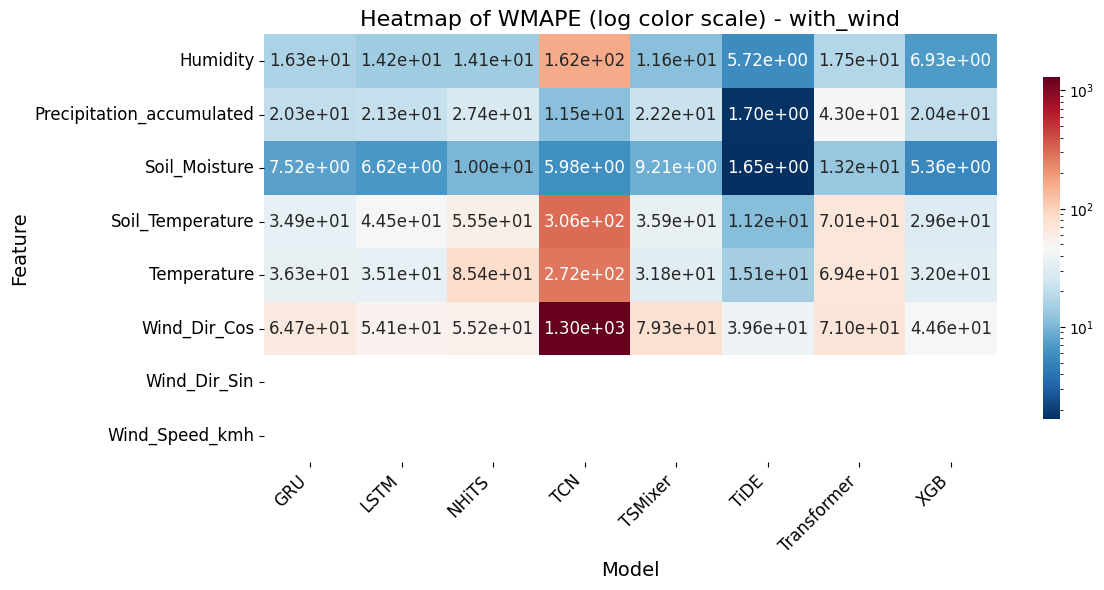

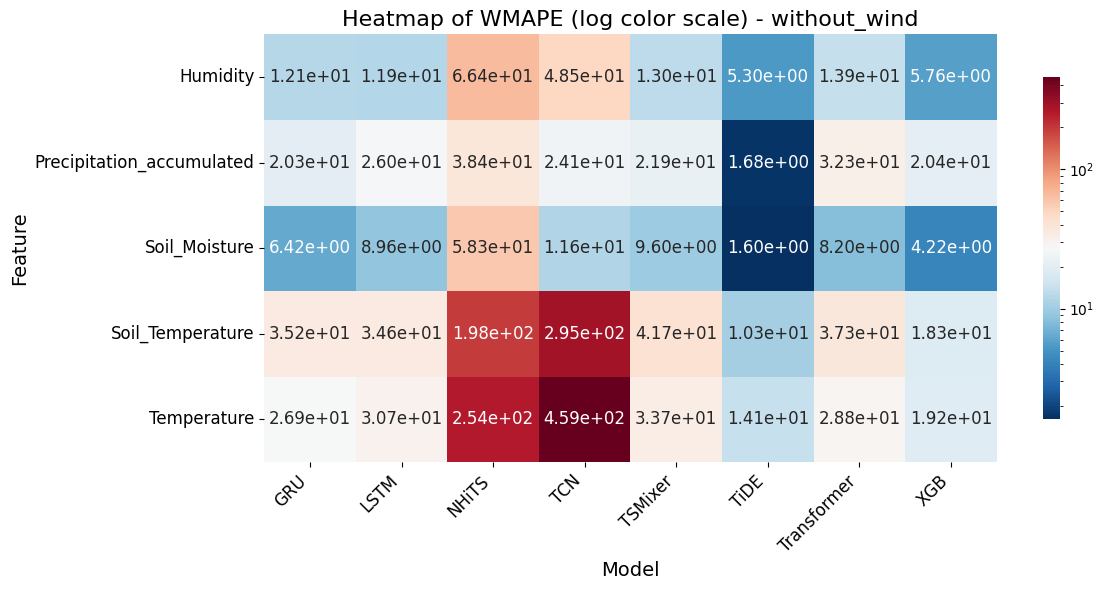

In [ ]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import os
from matplotlib.colors import LogNorm

# Caminhos dos arquivos avg_metrics.json
avg_metrics_files = glob.glob(os.path.join(RESULTS_PATH, '*', '*', 'avg_metrics.json'))

metricas = []
for file in avg_metrics_files:
    parts = file.split(os.sep)
    model = parts[-3]
    variant = parts[-2]
    with open(file, 'r') as f:
        data = json.load(f)
    for metric, features in data.items():
        for feature, value in features.items():
            metricas.append({
                'model': model,
                'variant': variant,
                'feature': feature,
                'metric': metric,
                'value': value
            })

if metricas:
    df = pd.DataFrame(metricas)
    # Substitui inf e -inf por NaN
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['value'].replace([np.inf, -np.inf], np.nan, inplace=True)
    print('Features únicas:', df['feature'].unique())
    print('Modelos únicos:', df['model'].unique())
    print('Variantes únicas:', df['variant'].unique())
    for metric in df['metric'].unique():
        for variant in df['variant'].unique():
            sub = df[(df['metric'] == metric) & (df['variant'] == variant)]
            if sub.empty:
                continue
            pivot = sub.pivot(index='feature', columns='model', values='value')
            print(f'\nMétrica: {metric} | Variante: {variant}')
            print(pivot)
            # Só plota se houver pelo menos um valor válido
            if pivot.notna().sum().sum() == 0:
                print(f"Sem dados válidos para {metric} - {variant}, gráfico não exibido.")
                continue
            # Aplica escala logarítmica se todos os valores positivos
            mask = pivot.isna()
            data_vals = pivot.values[~mask.values]
            use_log = np.all(data_vals > 0)
            plt.figure(figsize=(12, 6))
            if metric == 'R2':
                sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdBu_r', center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap of {metric} (centered at 0) - {variant}', fontsize=16)
            elif use_log:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='RdBu_r', norm=LogNorm(), annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap of {metric} (log color scale) - {variant}', fontsize=16)
            else:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='RdBu_r', center=0, annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap of {metric} - {variant}', fontsize=16)
            plt.ylabel('Feature', fontsize=14)
            plt.xlabel('Model', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(rotation=0, fontsize=12)
            plt.tight_layout()
            plt.savefig(f'../final_results_graphs/heatmaps_per_metric/heatmap_{metric}_{variant}.png', dpi=300, bbox_inches='tight')
else:
    print('No avg_metrics.json files found or no data to plot.')


In [ ]:
import glob
import json
import pandas as pd
import os
from plotnine import ggplot, aes, geom_bar, labs, theme_bw, theme, element_text

# Caminhos dos arquivos all_metrics.json
all_metrics_files = glob.glob(os.path.join(RESULTS_PATH, '*', '*', 'all_metrics.json'))

scatter_data = []
for file in all_metrics_files:
    parts = file.split(os.sep)
    model = parts[-3]
    variant = parts[-2]
    with open(file, 'r') as f:
        data = json.load(f)
    # O formato correto é data['all_folds']['fold_X'][metric][feature]
    if 'all_folds' in data:
        all_folds = data['all_folds']
        for fold_name, fold_metrics in all_folds.items():
            fold_idx = int(fold_name.replace('fold_', ''))
            for metric, features in fold_metrics.items():
                for feature, value in features.items():
                    scatter_data.append({
                        'model': model,
                        'variant': variant,
                        'fold': fold_idx,
                        'metric': metric,
                        'feature': feature,
                        'value': value
                    })

if scatter_data:
    df = pd.DataFrame(scatter_data)
    # Para cada modelo, variável e métrica, plota um gráfico de barras por fold usando plotnine
    for model in df['model'].unique():
        for feature in df['feature'].unique():
            for metric in df['metric'].unique():
                sub = df[(df['model'] == model) & (df['feature'] == feature) & (df['metric'] == metric)]
                if sub.empty:
                    continue
                p = (
                    ggplot(sub, aes(x='factor(fold)', y='value', fill='variant')) +
                    geom_bar(stat='identity', position='dodge') +
                    labs(title=f'{model} - {feature} - {metric}', x='Fold', y='Valor') +
                    theme_bw() +
                    theme(
                        axis_text_x=element_text(size=10),
                        axis_text_y=element_text(size=10),
                        figure_size=(8, 5)
                    )
                )
                p.save(f'../final_results_graphs/bars/bars_{model}_{feature}_{metric}.png', dpi=300, bbox_inches='tight')
else:
    print('No all_metrics.json files found or no data to plot.')


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/bars/bars_Transformer_Temperature_MSE.png
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/bars/bars_Transformer_Temperature_RMSE.png
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../final_results_graphs/bars/bars_Transformer_Temperature_MAE.png
/home/

In [11]:
import glob
import json
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Caminhos dos arquivos avg_metrics.json
avg_metrics_files = glob.glob(os.path.join(RESULTS_PATH, '*', '*', 'avg_metrics.json'))

heatmap_data = []
for file in avg_metrics_files:
    parts = file.split(os.sep)
    model = parts[-3]
    variant = parts[-2]
    with open(file, 'r') as f:
        data = json.load(f)
    for metric, features in data.items():
        for feature, value in features.items():
            heatmap_data.append({
                'model': model,
                'variant': variant,
                'metric': metric,
                'feature': feature,
                'value': value
            })

if heatmap_data:
    df = pd.DataFrame(heatmap_data)
    for feature in df['feature'].unique():
        for metric in df['metric'].unique():
            sub = df[(df['feature'] == feature) & (df['metric'] == metric)]
            if sub.empty:
                continue
            pivot = sub.pivot(index='model', columns='variant', values='value')
            # Aplica escala logarítmica nas cores se todos os valores forem positivos e finitos
            mask = pivot.isna()
            data_vals = pivot.values[~mask.values]
            use_log = np.all((data_vals > 0) & np.isfinite(data_vals)) and data_vals.size > 0
            plt.figure(figsize=(8, 5))
            if use_log:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='YlGnBu', norm=LogNorm(), annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap (log color) - {feature} - {metric}')
            else:
                sns.heatmap(pivot, annot=True, fmt='.2e', cmap='YlGnBu', annot_kws={"size":12}, cbar_kws={"shrink":0.8}, mask=mask)
                plt.title(f'Heatmap - {feature} - {metric}')
            plt.ylabel('Modelo')
            plt.xlabel('Variante')
            plt.tight_layout()
            plt.savefig(f'../final_results_graphs/heatmaps_per_metric_var/heatmap_{feature}_{metric}.png', dpi=300, bbox_inches='tight')
else:
    print('No avg_metrics.json files found or no data to plot.')